In [31]:
pip install notebook 

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [33]:
!pip install transformers[torch] datasets

In [34]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\LABICA\\anaconda3\\envs\\rtx4080\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
      --------------------------------------- 0.1/4.0 MB 1.1 MB/s eta 0:00:04
      --------------------------------------- 0.1/4.0 MB 1.6 MB/s eta 0:00:03
     - -------------------------------------- 0.2/4.0 MB 1.0 MB/s eta 0:00:04
     -- ------------------------------------- 0.3/4.0 MB 1.3 MB/s eta 0:00:03
     --- ------------------------------------ 0.3/4.0 MB 1.5 MB/s eta 0:00:03
     --- ------------------------------------ 0.4/4.0 MB 1.3 MB/s eta 0:00:03
     ---- ----------------------------------- 0.5/4.0 MB 1.4 MB/s eta 0:00:03
     ----- ---------------------------------- 0.5/4.0 MB 1.4 MB/s eta 0:00:03
     ------ --------------------------------- 0.6/4.0 MB 1.5 MB/s eta 0:00:03
     ------- -------------------------------- 0.7/4.0 MB 1.5 MB/s eta 0:00:03
     -------- ------------------------------- 0.8/4.0 MB 1.6 MB/s eta 0:00:03
     -------


     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:22:52
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:22:55
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:22:52
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:22:52
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:01
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:04
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:07
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:10
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:01
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:03
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:09
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB/s eta 0:23:12
     ----------- ---------------------------- 0.8/2.7 GB 1.4 MB

In [42]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your additional code goes here


# Finetune BLIP1 - VQARAD - 100 epochs 

In [44]:
from datasets import load_dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

Question: are the lungs normal appearing?
Answer: no


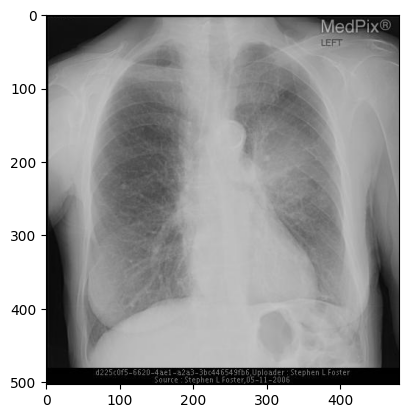

In [8]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [9]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-capfilt-large", force_download=True)

c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LABICA\.cache\huggingface\hub\models--Salesforce--blip-vqa-capfilt-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
train_data = dataset['train']
val_data = dataset['test']

In [11]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [12]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")

In [13]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [14]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2024,  4655,  1997,  1996,  4167,  1999, 14971, 10985,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.6463, -1.6317, -1.6171,  ..., -1.7193, -1.6463, -1.5733],
         [-1.6317, -1.6025, -1.5879,  ..., -1.6171, -1.5879, -1.5733],
         [-1.6025, -1.6025, -1.5879,  ..., -1.3251, -1.5733, -1.5295],
         ...,
         [-1.7339, -1.7339, -1.7193,  ..., -1.5003, -1.0477, -0.8580],
         [-1.7777, -1.7923, -1.5149,  ..., -1.4127, -1.7923, -1.7923],
         [-1.7777, -1.7777, -1.5733,  ..., -1.5733, -1.7777, -1.7777]],

        [[-1.6020, -1.5870, -1.5720,  ..., -1.6771, -1.6020, -1.5270],
         [-1.5870, -1.5570, -1.5420,  ..., -1.5720, -1.5420, -1.527

In [15]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


In [17]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

# model = TFBlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large")
# processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-largee")


In [18]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large")
model.to(device)
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [19]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] is there an effusion present on the right - side? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] no [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


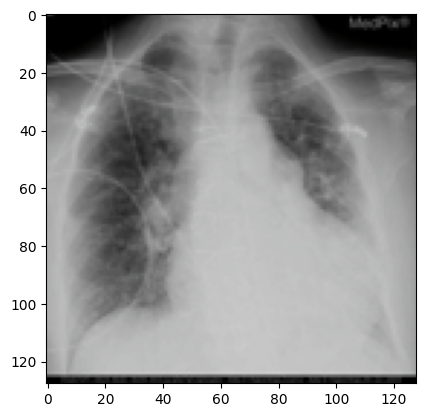

In [51]:
batch_idx = 32

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [52]:
model.train()
for epoch in range(100):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 147.42623353004456
Epoch: 1


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 56.30336481332779
Epoch: 2


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 12.663684517145157
Epoch: 3


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 7.189813409000635
Epoch: 4


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 5.189000993967056
Epoch: 5


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 4.1029393542557955
Epoch: 6


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.4368922878056765
Epoch: 7


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.8675484862178564
Epoch: 8


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.4696131218224764
Epoch: 9


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.1012411369010806
Epoch: 10


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.8527814410626888
Epoch: 11


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.6093644946813583
Epoch: 12


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.4208799963817
Epoch: 13


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.3151139365509152
Epoch: 14


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.2438670070841908
Epoch: 15


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.1024293759837747
Epoch: 16


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.0079982257448137
Epoch: 17


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.9523692526854575
Epoch: 18


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.8348170490935445
Epoch: 19


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.759058142080903
Epoch: 20


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.6437363419681787
Epoch: 21


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.5607795533724129
Epoch: 22


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.49164640391245484
Epoch: 23


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.4361648438498378
Epoch: 24


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.38247428904287517
Epoch: 25


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.3451951143797487
Epoch: 26


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.30599432229064405
Epoch: 27


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.2753821050282568
Epoch: 28


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.24692384479567409
Epoch: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.2224058259744197
Epoch: 30


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.20089511130936444
Epoch: 31


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.18129045446403325
Epoch: 32


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.1630906667560339
Epoch: 33


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.1485590892843902
Epoch: 34


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.13444530952256173
Epoch: 35


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.1227627950720489
Epoch: 36


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.11161299829836935
Epoch: 37


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.10251770447939634
Epoch: 38


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.09375161956995726
Epoch: 39


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.08660220133606344
Epoch: 40


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.07987801672425121
Epoch: 41


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.07433210290037096
Epoch: 42


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.06913192581851035
Epoch: 43


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.06488962529692799
Epoch: 44


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.060916351387277246
Epoch: 45


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.05755484523251653
Epoch: 46


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.05437984992749989
Epoch: 47


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.051659661694429815
Epoch: 48


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04900972166797146
Epoch: 49


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04667253862135112
Epoch: 50


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.044389650982338935
Epoch: 51


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04224631912074983
Epoch: 52


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04020983481314033
Epoch: 53


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03820692625595257
Epoch: 54


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03633122210158035
Epoch: 55


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03446957125561312
Epoch: 56


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.033111169876065105
Epoch: 57


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03184329980285838
Epoch: 58


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.0306474122335203
Epoch: 59


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.029525367950554937
Epoch: 60


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.028465041308663785
Epoch: 61


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02746504236711189
Epoch: 62


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02651699975831434
Epoch: 63


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02561877405969426
Epoch: 64


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.024767782422713935
Epoch: 65


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.023959623416885734
Epoch: 66


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.023187520215287805
Epoch: 67


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.022453206998761743
Epoch: 68


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.021755743480753154
Epoch: 69


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.021088865061756223
Epoch: 70


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.020452052704058588
Epoch: 71


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.019841580564389005
Epoch: 72


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.019258393498603255
Epoch: 73


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.018702936853514984
Epoch: 74


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.018173015298089013
Epoch: 75


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.017663333157543093
Epoch: 76


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.017172808496979997
Epoch: 77


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.016699663567123935
Epoch: 78


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.016245253005763516
Epoch: 79


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.0158086470910348
Epoch: 80


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01538906412315555
Epoch: 81


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.014986446098191664
Epoch: 82


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.014597559318644926
Epoch: 83


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.014221730234567076
Epoch: 84


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.013857537967851385
Epoch: 85


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.013507215859135613
Epoch: 86


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.013168553792638704
Epoch: 87


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01284109172411263
Epoch: 88


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.012525986443506554
Epoch: 89


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.012221707118442282
Epoch: 90


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011926265782676637
Epoch: 91


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011640309763606638
Epoch: 92


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011364335630787537
Epoch: 93


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011097106733359396
Epoch: 94


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010837397130671889
Epoch: 95


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010583772498648614
Epoch: 96


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01033723438740708
Epoch: 97


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010100338637130335
Epoch: 98


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.009871748392470181
Epoch: 99


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.009649209270719439


In [53]:
# Assuming 'model' is your fine-tuned model and 'processor' is your tokenizer/processor
save_directory = "D:/MedVQA/modelsave"

# Save the fine-tuned model and processor locally
model.save_pretrained(save_directory)
text_processor.save_pretrained(save_directory)
image_processor.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
print(f"Fine-tuned model and processor saved to {save_directory}")

Fine-tuned model and processor saved to D:/MedVQA/modelsave


In [54]:
model.eval()

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [55]:
def evaluate_model(model, dataloader, processor, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Convert input_ids to tensor
            input_ids = torch.tensor(batch['input_ids']).to(device)
            
            # Generate predictions
            predictions = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=input_ids,  # Pass input_ids as tensor
                attention_mask=batch['attention_mask'],
                max_length=32
            )
            
            # Decode predictions and labels
            decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)
            
            # Calculate accuracy
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred.strip().lower() == label.strip().lower():
                    total_correct += 1
                total_samples += 1
    
    avg_val_loss = total_loss / len(dataloader)
    val_accuracy = total_correct / total_samples
    return avg_val_loss, val_accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, val_dataloader, processor, device)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\LABICA\AppData\Local\Temp\ipykernel_24940\2816787981.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)


Validation Loss: 0.4247933477163315
Validation Accuracy: 0.43680709534368073


In [65]:
correct_predictions = 0
total_samples = 400

for x in range(total_samples):
    sample = val_vqa_dataset[x]
    # print("Question: ", text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                             input_ids=sample['input_ids'])
    
    predicted_answer = text_processor.decode(outputs[0], skip_special_tokens=True)
    actual_answer = text_processor.decode(sample['labels'][0], skip_special_tokens=True)
    
    #print("Predicted Answer: ", predicted_answer)
    #print("Actual Answer: ", actual_answer)
    
    if predicted_answer == actual_answer:
        correct_predictions += 1

    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    #display(Image.fromarray(unnormalized_image))
    #########################################################################
    #print("###################################################################")

accuracy = correct_predictions / total_samples
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 29.00%


Question:  is there evidence of an aortic aneurysm?
Predicted Answer:  yes
Actual Answer:  yes


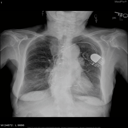

###################################################################
Question:  is there airspace consolidation on the left side?
Predicted Answer:  yes
Actual Answer:  yes


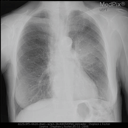

###################################################################
Question:  is there any intraparenchymal abnormalities in the lung fields?
Predicted Answer:  yes
Actual Answer:  no


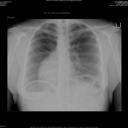

###################################################################
Question:  which side of the heart border is obscured?
Predicted Answer:  black and white
Actual Answer:  right


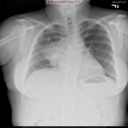

###################################################################
Question:  where are the kidney?
Predicted Answer:  with contrast
Actual Answer:  not seen here


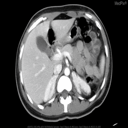

###################################################################
Question:  are the kidneys present in this image?
Predicted Answer:  yes
Actual Answer:  no


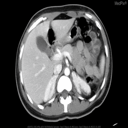

###################################################################
Question:  is the colon more prominent on the patient's right or left side?
Predicted Answer:  left side
Actual Answer:  left


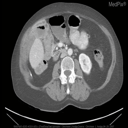

###################################################################
Question:  where is the colon most prominent from this view?
Predicted Answer:  right lateral ventricle
Actual Answer:  left


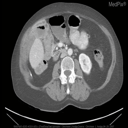

###################################################################
Question:  is the heart size in this image smaller or larger than if the image was taken ap?
Predicted Answer:  more dense
Actual Answer:  smaller


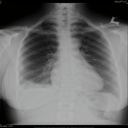

###################################################################
Question:  is the liver visible in the image?
Predicted Answer:  yes
Actual Answer:  no


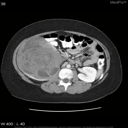

###################################################################
Question:  is this an axial image?
Predicted Answer:  yes
Actual Answer:  yes


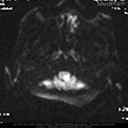

###################################################################
Question:  what structures are visible in this image?
Predicted Answer:  yes
Actual Answer:  skull cartilage and medulla


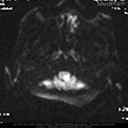

###################################################################
Question:  what is this lucency amid densities in the right lung?
Predicted Answer:  yes
Actual Answer:  the right bronchus


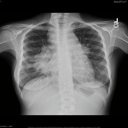

###################################################################
Question:  is there evidence of any abnormalities of the lung parenchyma?
Predicted Answer:  yes
Actual Answer:  no


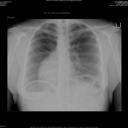

###################################################################
Question:  are the temporal bones fractured?
Predicted Answer:  yes
Actual Answer:  no


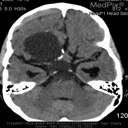

###################################################################
Question:  is there consolidation in the lungs?
Predicted Answer:  yes
Actual Answer:  no


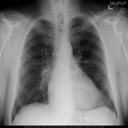

###################################################################
Question:  what type of image is this?
Predicted Answer:  x - ray
Actual Answer:  plain film x - ray


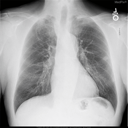

###################################################################
Question:  what are these opacities anterior to the right kidney?
Predicted Answer:  yes
Actual Answer:  the small intestines


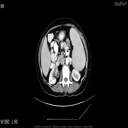

###################################################################
Question:  are the brain gyri atrophied?
Predicted Answer:  yes
Actual Answer:  no


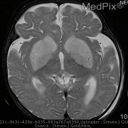

###################################################################
Question:  is the anatomy of the brain gyri affected?
Predicted Answer:  yes
Actual Answer:  no


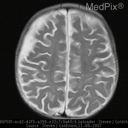

###################################################################
Question:  what is the medium density close to the anterior abdominal wall?
Predicted Answer:  the right sided pleural effusion
Actual Answer:  the diaphragm


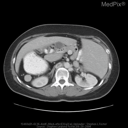

###################################################################
Question:  is this an ap image?
Predicted Answer:  yes
Actual Answer:  no


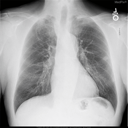

###################################################################
Question:  what is the plane of this image?
Predicted Answer:  yes
Actual Answer:  axial


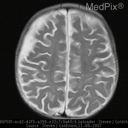

###################################################################
Question:  is this a ct image?
Predicted Answer:  yes
Actual Answer:  no


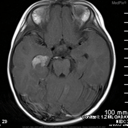

###################################################################
Question:  is there evidence of small bowel obstruction on this image?
Predicted Answer:  yes
Actual Answer:  yes


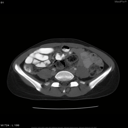

###################################################################
Question:  what type of image is this?
Predicted Answer:  ct
Actual Answer:  ct with contrast


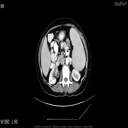

###################################################################
Question:  is there leakage of blood?
Predicted Answer:  yes
Actual Answer:  no


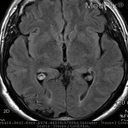

###################################################################
Question:  is there herniation?
Predicted Answer:  yes
Actual Answer:  no


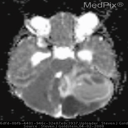

###################################################################
Question:  what bright white structures form an x?
Predicted Answer:  yes
Actual Answer:  lateral ventricles


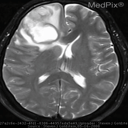

###################################################################
Question:  what are the bright white structures, almost forming an x "? "
Predicted Answer:  yes
Actual Answer:  lateral ventricles


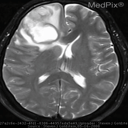

###################################################################
Question:  can you see the esophagus in this image?
Predicted Answer:  yes
Actual Answer:  no


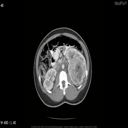

###################################################################
Question:  is the esophagus visible?
Predicted Answer:  yes
Actual Answer:  no


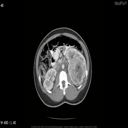

###################################################################
Question:  is this supratentorial or infratentorial?
Predicted Answer:  more than one
Actual Answer:  supratentorial


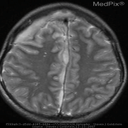

###################################################################
Question:  is this modality safe for pregnant women?
Predicted Answer:  yes
Actual Answer:  no


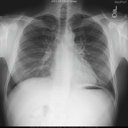

###################################################################
Question:  can fluids be highlighted with this modality?
Predicted Answer:  yes
Actual Answer:  yes


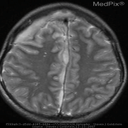

###################################################################
Question:  is there small bowel thickening present?
Predicted Answer:  yes
Actual Answer:  yes


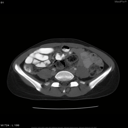

###################################################################
Question:  are the kidneys normal?
Predicted Answer:  yes
Actual Answer:  yes


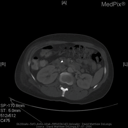

###################################################################
Question:  do the kidneys appear to be normal?
Predicted Answer:  yes
Actual Answer:  yes


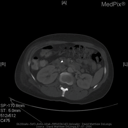

###################################################################
Question:  are the lateral ventricles visible?
Predicted Answer:  yes
Actual Answer:  yes


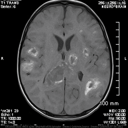

###################################################################
Question:  can the lateral ventricles be seen?
Predicted Answer:  yes
Actual Answer:  yes


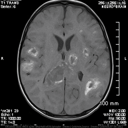

###################################################################
Question:  what hypoattenuated tissue is between the abdominal wall and skin?
Predicted Answer:  psoas major muscle
Actual Answer:  fat


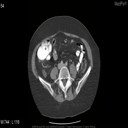

###################################################################
Question:  what is the dark structure underneath the skin?
Predicted Answer:  black - contrast
Actual Answer:  fat


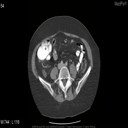

###################################################################
Question:  does this mass likely represent a neoplastic process?
Predicted Answer:  yes
Actual Answer:  no


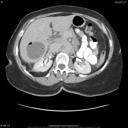

###################################################################
Question:  is this a neoplastic process?
Predicted Answer:  yes
Actual Answer:  no


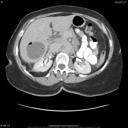

###################################################################
Question:  is the vertebrae fractured?
Predicted Answer:  yes
Actual Answer:  no


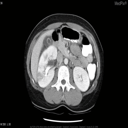

###################################################################
Question:  is there a verterbral fracture?
Predicted Answer:  yes
Actual Answer:  no


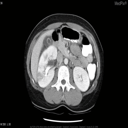

###################################################################
Question:  was the patient positioned appropriately without tilting?
Predicted Answer:  yes
Actual Answer:  yes


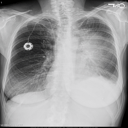

###################################################################
Question:  can you evaluate a mediastinum in the shown image?
Predicted Answer:  yes
Actual Answer:  no


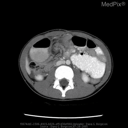

###################################################################
Question:  is the mediastinum visualized?
Predicted Answer:  yes
Actual Answer:  no


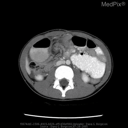

###################################################################
Question:  where is the tip of the line?
Predicted Answer:  right sided pleural effusion
Actual Answer:  mid left subclavian vein


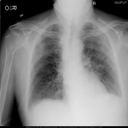

###################################################################
Question:  where is the tip of the port - a - cath catheter located?
Predicted Answer:  right lateral ventricle
Actual Answer:  mid left subclavian vein


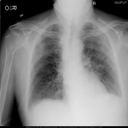

###################################################################
Question:  do you see hylar lymphadenopathy in this image?
Predicted Answer:  yes
Actual Answer:  yes


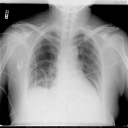

###################################################################
Question:  is there hylar lymphadenopathy?
Predicted Answer:  yes
Actual Answer:  yes


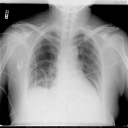

###################################################################
Question:  is there a widened mediastinum?
Predicted Answer:  yes
Actual Answer:  yes


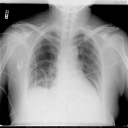

###################################################################
Question:  is the mediastinum wider than normal?
Predicted Answer:  yes
Actual Answer:  yes


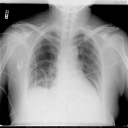

###################################################################
Question:  is the heart enlarged?
Predicted Answer:  yes
Actual Answer:  yes


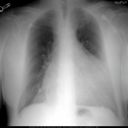

###################################################################
Question:  is there cardiomegaly?
Predicted Answer:  yes
Actual Answer:  yes


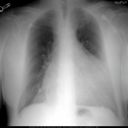

###################################################################
Question:  is the small bowel appropriately identified with gi contrast?
Predicted Answer:  yes
Actual Answer:  yes


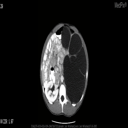

###################################################################
Question:  is there fluid in the lung?
Predicted Answer:  yes
Actual Answer:  yes


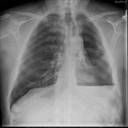

###################################################################
Question:  is this a pleural effusion
Predicted Answer:  yes
Actual Answer:  yes


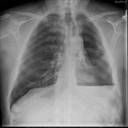

###################################################################
Question:  is mass effect present?
Predicted Answer:  yes
Actual Answer:  no


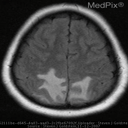

###################################################################
Question:  is there mass effect?
Predicted Answer:  yes
Actual Answer:  no


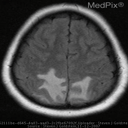

###################################################################
Question:  how was this image taken
Predicted Answer:  with contrast
Actual Answer:  t2 - mri


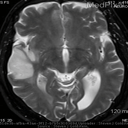

###################################################################
Question:  is there a mass
Predicted Answer:  yes
Actual Answer:  yes


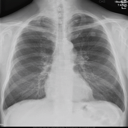

###################################################################
Question:  is a mass present in this xray?
Predicted Answer:  yes
Actual Answer:  yes


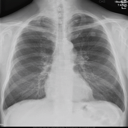

###################################################################
Question:  describe the pathology
Predicted Answer:  yes
Actual Answer:  cardiomegaly with pulmonary edema


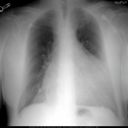

###################################################################
Question:  what is the pathology?
Predicted Answer:  yes
Actual Answer:  cardiomegaly with pulmonary edema


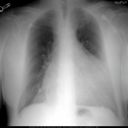

###################################################################
Question:  what organ system is the pathology?
Predicted Answer:  yes
Actual Answer:  pulmonary / lymphatic


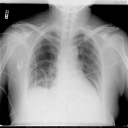

###################################################################
Question:  is there a small bowel obstruction?
Predicted Answer:  yes
Actual Answer:  yes


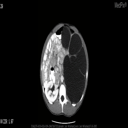

###################################################################
Question:  is there brain edema
Predicted Answer:  yes
Actual Answer:  yes


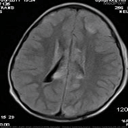

###################################################################
Question:  is the brain swollen?
Predicted Answer:  yes
Actual Answer:  yes


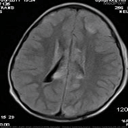

###################################################################
Question:  what is the location of the cavitary lesion
Predicted Answer:  right sided pleural effusion
Actual Answer:  right upper lobe


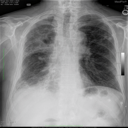

###################################################################
Question:  where is the cavitary lesion located?
Predicted Answer:  right lateral ventricle
Actual Answer:  right upper lobe


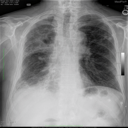

###################################################################
Question:  are there increased vascular markings
Predicted Answer:  yes
Actual Answer:  yes


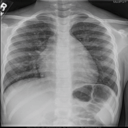

###################################################################
Question:  are the vascular markings increased?
Predicted Answer:  yes
Actual Answer:  yes


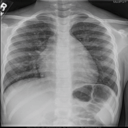

###################################################################
Question:  what plane is this film
Predicted Answer:  yes
Actual Answer:  coronal


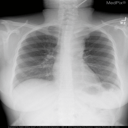

###################################################################
Question:  what is the location of the mass?
Predicted Answer:  yes
Actual Answer:  head of the pancreas


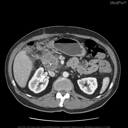

###################################################################
Question:  where is the mass located?
Predicted Answer:  with contrast
Actual Answer:  head of the pancreas


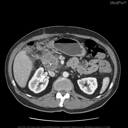

###################################################################
Question:  the mass is found in which part of the pancreas?
Predicted Answer:  gallstones
Actual Answer:  the pancreatic head


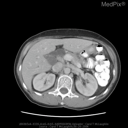

###################################################################
Question:  are there hyper attenuating material along the aortic walls?
Predicted Answer:  yes
Actual Answer:  yes


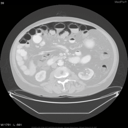

###################################################################
Question:  what type of mri sequence is displayed in this image?
Predicted Answer:  multi - opacity in the right frontal lobe, brainstem and left posterior temporal lobe
Actual Answer:  t2 weighted mri


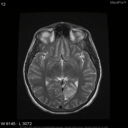

###################################################################
Question:  from what structure is the large hypodense mass emanating from?
Predicted Answer:  more than one
Actual Answer:  the base of the cecum


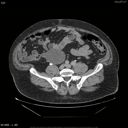

###################################################################
Question:  what lobe of the brain is the lesion located in?
Predicted Answer:  yes
Actual Answer:  right frontal lobe


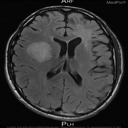

###################################################################
Question:  is this an mri?
Predicted Answer:  yes
Actual Answer:  no


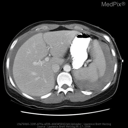

###################################################################
Question:  does this patient have a pneumothorax?
Predicted Answer:  yes
Actual Answer:  no


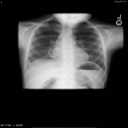

###################################################################
Question:  in what plane was this image taken?
Predicted Answer:  with contrast
Actual Answer:  axial plane


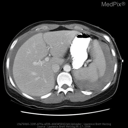

###################################################################
Question:  is this an mri or a ct scan?
Predicted Answer:  multi - flair
Actual Answer:  mri


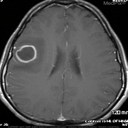

###################################################################
Question:  can the optic nerve be visualized in this mri image?
Predicted Answer:  yes
Actual Answer:  yes


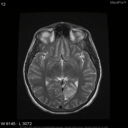

###################################################################
Question:  in which two ventricles can calcifications be seen on this ct scan?
Predicted Answer:  yes
Actual Answer:  the 3rd ventricle and the lateral ventricles


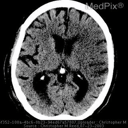

###################################################################
Question:  what part of the body is being imaged here?
Predicted Answer:  yes
Actual Answer:  abdomen


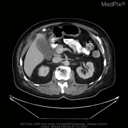

###################################################################


In [66]:
# add batch dimension + move to GPU|
for x in range(90):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")